In [1]:
import torch
import torchani
from torchani.datasets import ANIDataset
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torchani.units import hartree2kcalmol

/home/nick/TorchANI_sandbox/torchani/infer.py:16: UserWarning: mnp not installed
  warnings.warn("mnp not installed")
/home/nick/TorchANI_sandbox/torchani/aev/aev_computer.py:24: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


In [2]:
ani2x = torchani.models.ANI2x(periodic_table_index=True)

/home/nick/TorchANI_sandbox/torchani/models.py:103: UserWarning: The default is now to accept atomic numbers as indexes, do not set periodic_table_index=True. if you need to accept raw indices set periodic_table_index=False
  warnings.warn("The default is now to accept atomic numbers as indexes,"


In [3]:
dataset_path = Path('/home/nick/First_DSs/ANI-2x-first-conformers.h5')

In [4]:
ds = ANIDataset(locations=(dataset_path), names=('ANI-2x-first-conformers'))

In [5]:
print('Conformers in dataset:',len(ds))

Conformers in dataset: 9391


In [6]:
df = pd.read_csv('df_2x.csv')

Made into markdown since you only need to run the DF code once, then just load the csv later

df = pd.DataFrame(columns=['Formula','Species','Avg_AE','Stdev','QBC'])
count = 0
formula_list = []
species_list = []
avg_ae_list = []
stdev_list = []
qbc_list = []


for index, formula in enumerate(ds.keys()):
    #print('Molecular formula:\n',formula)
    
    conformer = ds.get_conformers(formula)    
    species = conformer['species']
    #print(species)
    coordinates = conformer['coordinates']
    ani_input = (species,coordinates)
    #mol_e = ani2x(ani_input).energies
    #print('Molecular energy:\n',mol_e.detach().item(), 'Hartree')
    _, energies, qbc_factor = ani2x.energies_qbcs(ani_input)
        
    species_index, ae = ani2x.atomic_energies(ani_input, average=False, with_SAEs=False)
    #print('Atomic energy contributions (no SAEs):\n',ae.detach(),'in Hartree')
    
    avg_ae = ae.mean(0).tolist()
    #print('Average atomic energy contribution:\n',avg_ae[0],'in Hartree')
    
    stdev_ae = ae.std(0).tolist()
    #print('Stdev in atomic energies across the ensemble:\n',stdev_ae.detach()[0],'in Hartree')
    
    coef_var = (ae.std(0)/abs(ae.mean(0))).tolist()
    #print('Coefficient of variation in atomic energies:\n',coef_var[0])
    
    for atoms in avg_ae[0]:
        formula_list.append(formula)
        # Want a chemical formula and qbc factor attached to each atom type
        qbc_list.append(qbc_factor.detach().numpy())
    
    #print(formula_list)
    species_list.extend(species.tolist()[0])
    #print(species_list)
    avg_ae_list.extend(avg_ae[0])
    #print(avg_ae_list)
    stdev_list.extend(stdev_ae[0])
    #print(stdev_list)
    
    
    # Counter to stop iterating:
    #count += 1
    #if count == 25:
    #    break


df['Species'] = species_list
df['Avg_AE'] = avg_ae_list
df['Stdev'] = stdev_list
df['Formula'] = formula_list
df['QBC'] = qbc_list
print(df)
df.to_csv('df_2x.csv')

In [7]:
mol_in_ds = len(ds)
atoms_in_ds = len(df['QBC'])
avg_N = atoms_in_ds/mol_in_ds
print(avg_N)

18.880097966137793


In [8]:
df['QBC'].to_numpy()

array(['[0.00040447]', '[0.00040447]', '[0.00040447]', ...,
       '[0.00033025]', '[0.00033025]', '[0.00033025]'], dtype=object)

In [9]:
df_by_species = df.set_index('Species')
print(df.loc[df['Formula'] == 'C2H6'])
print(df.loc[df['Formula'] == 'C2H4'])
print(df.loc[df['Formula'] == 'C2H2'])

       Unnamed: 0 Formula  Species    Avg_AE     Stdev             QBC
52908       52908    C2H6        6  0.007233  0.007753  [7.771798e-05]
52909       52909    C2H6        6  0.003858  0.008247  [7.771798e-05]
52910       52910    C2H6        1  0.006392  0.002390  [7.771798e-05]
52911       52911    C2H6        1  0.008041  0.002381  [7.771798e-05]
52912       52912    C2H6        1  0.011016  0.003213  [7.771798e-05]
52913       52913    C2H6        1  0.005589  0.002388  [7.771798e-05]
52914       52914    C2H6        1  0.007314  0.003068  [7.771798e-05]
52915       52915    C2H6        1  0.002842  0.002834  [7.771798e-05]
       Unnamed: 0 Formula  Species    Avg_AE     Stdev           QBC
51689       51689    C2H4        6  0.010595  0.005950  [0.00015004]
51690       51690    C2H4        6  0.011401  0.005852  [0.00015004]
51691       51691    C2H4        1 -0.002668  0.003125  [0.00015004]
51692       51692    C2H4        1 -0.000839  0.002903  [0.00015004]
51693       5169

In [10]:
h_df = df_by_species.loc[1]
c_df = df_by_species.loc[6]
n_df = df_by_species.loc[7]
o_df = df_by_species.loc[8]
s_df = df_by_species.loc[16]
f_df = df_by_species.loc[9]
cl_df= df_by_species.loc[17]

#print(h_df,'\n',c_df,'\n',n_df,'\n',o_df,'\n',s_df,'\n',f_df,'\n',cl_df)

In [15]:
max_c_stdev = c_df['Stdev'].argmax()
c_df.iloc[max_c_stdev]

Unnamed: 0           95303
Formula          C4ClH3N6S
Avg_AE            0.088626
Stdev             0.026513
QBC           [0.01012552]
Name: 6, dtype: object

In [12]:
df.loc[df['Formula'] == 'CH4']

,Unnamed: 0,Formula,Species,Avg_AE,Stdev,QBC
175828,175828,CH4,6,0.003604,0.012626,[8.049696e-05]
175829,175829,CH4,1,-0.004999,0.003335,[8.049696e-05]
175830,175830,CH4,1,0.001886,0.002752,[8.049696e-05]
175831,175831,CH4,1,0.000060,0.003487,[8.049696e-05]
175832,175832,CH4,1,-0.004752,0.003177,[8.049696e-05]


In [13]:
df.loc[df['Formula'] == 'C4ClH3N6S']

,Unnamed: 0,Formula,Species,Avg_AE,Stdev,QBC
95301,95301,C4ClH3N6S,6,-0.006587,0.004778,[0.01012552]
95302,95302,C4ClH3N6S,6,0.020402,0.008196,[0.01012552]
95303,95303,C4ClH3N6S,6,0.088626,0.026513,[0.01012552]
95304,95304,C4ClH3N6S,6,-0.015045,0.008012,[0.01012552]
95305,95305,C4ClH3N6S,1,-0.002438,0.002737,[0.01012552]
95306,95306,C4ClH3N6S,1,0.002976,0.003796,[0.01012552]
95307,95307,C4ClH3N6S,1,-0.003468,0.002894,[0.01012552]
95308,95308,C4ClH3N6S,7,-0.021311,0.007506,[0.01012552]
95309,95309,C4ClH3N6S,7,0.036410,0.016331,[0.01012552]
95310,95310,C4ClH3N6S,7,-0.013385,0.004255,[0.01012552]


In [17]:
h_energies = h_df['Avg_AE'].to_numpy()
h_stdev = h_df['Stdev'].to_numpy()

c_energies = c_df['Avg_AE'].to_numpy()
c_stdev = c_df['Stdev'].to_numpy()

n_energies = n_df['Avg_AE'].to_numpy()
n_stdev = n_df['Stdev'].to_numpy()

o_energies = o_df['Avg_AE'].to_numpy()
o_stdev = o_df['Stdev'].to_numpy()

s_energies = s_df['Avg_AE'].to_numpy()
s_stdev = s_df['Stdev'].to_numpy()

f_energies = f_df['Avg_AE'].to_numpy()
f_stdev = f_df['Stdev'].to_numpy()

cl_energies = cl_df['Avg_AE'].to_numpy()
cl_stdev = cl_df['Stdev'].to_numpy()

In [18]:
for i, j in [(h_energies, h_stdev), (c_energies, c_stdev), (n_energies, n_stdev), (o_energies, o_stdev), (s_energies, s_stdev), (f_energies, f_stdev), (cl_energies, cl_stdev)]:
    print(abs(j.mean())/i.mean())

-13.178818287416846
-5.8031018391206635
-1.6036344965118408
1.1294332761215713
-1.3877235477589775
-0.8334721980445263
0.4029284174727106


In [20]:
s_energies, f_energies, cl_energies
s_stdev, f_stdev, cl_stdev

(array([0.00422165, 0.00280199, 0.00563715, ..., 0.0046695 , 0.00563176,
        0.01229786]),
 array([0.00321445, 0.00363253, 0.00360288, ..., 0.00334236, 0.00286719,
        0.00835601]),
 array([0.00309286, 0.00466223, 0.00335159, ..., 0.00333896, 0.00286249,
        0.02124855]))

In [21]:
h_E_range = np.max(h_energies)-np.min(h_energies)
print('Range of H energies',h_E_range,'Hartree')
c_E_range = np.max(c_energies)-np.min(c_energies)
print('Range of C energies',c_E_range,'Hartree')
n_E_range = np.max(n_energies)-np.min(n_energies)
print('Range of N energies',n_E_range,'Hartree')
o_E_range = np.max(o_energies)-np.min(o_energies)
print('Range of O energies',o_E_range,'Hartree')
s_E_range = np.max(s_energies)-np.min(s_energies)
print('Range of S energies',s_E_range,'Hartree')
f_E_range = np.max(f_energies)-np.min(f_energies)
print('Range of F energies',f_E_range,'Hartree')
cl_E_range = np.max(cl_energies)-np.min(cl_energies)
print('Range of Cl energies',cl_E_range,'Hartree')

Range of H energies 0.2568157743662595 Hartree
Range of C energies 0.254206996411085 Hartree
Range of N energies 0.20909887179732312 Hartree
Range of O energies 0.2864176407456397 Hartree
Range of S energies 0.369488626718521 Hartree
Range of F energies 0.3642262518405913 Hartree
Range of Cl energies 0.6091589517891406 Hartree


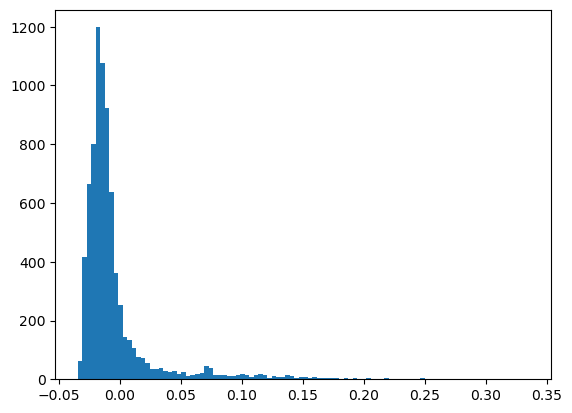

Avg energy: -0.0034403547419973217
Avg stdev: 0.004774261288113945


In [40]:
# S energies
plt.hist(s_energies, bins=100)
plt.show()
print('Avg energy:',np.mean(s_energies))
print('Avg stdev:',np.mean(s_stdev))

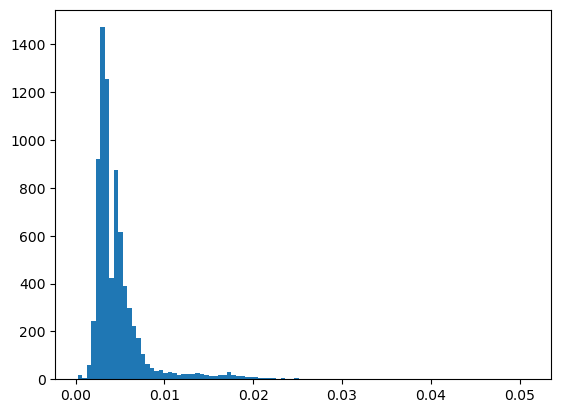

Avg energy: -0.0034403547419973217
Avg stdev: 0.004774261288113945


In [41]:
# S stdev
plt.hist(s_stdev, bins=100)
plt.show()
print('Avg energy:',np.mean(s_energies))
print('Avg stdev:',np.mean(s_stdev))

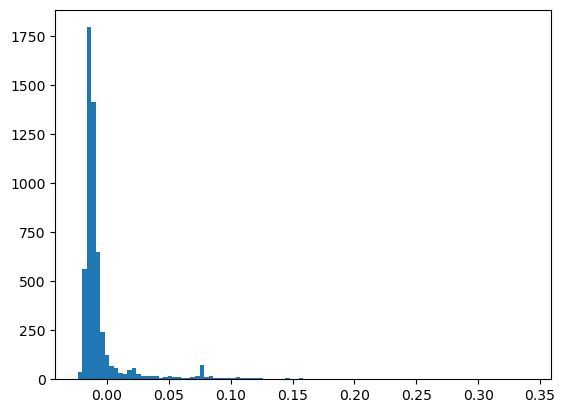

Avg energy: -0.004091402266349983
Avg stdev: 0.003410070040019077


In [42]:
# F energies
plt.hist(f_energies, bins=100)
plt.show()
print('Avg energy:',np.mean(f_energies))
print('Avg stdev:',np.mean(f_stdev))

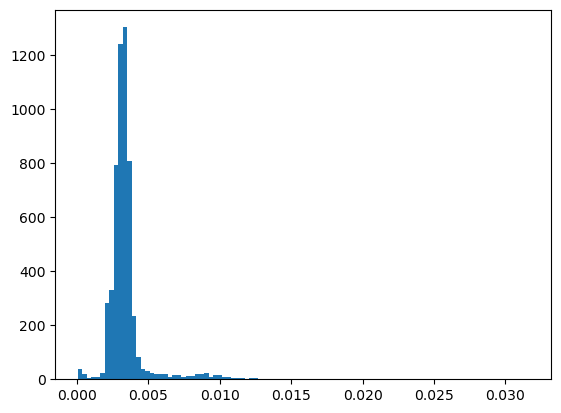

Avg energy: -0.004091402266349983
Avg stdev: 0.003410070040019077


In [43]:
# F stdev
plt.hist(f_stdev, bins=100)
plt.show()
print('Avg energy:',np.mean(f_energies))
print('Avg stdev:',np.mean(f_stdev))

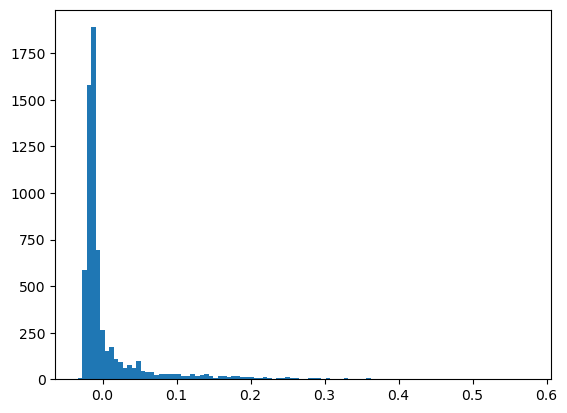

Avg energy: 0.009048193518440568
Avg stdev: 0.003645774295372095


In [44]:
# Cl energies
plt.hist(cl_energies, bins=100)
plt.show()
print('Avg energy:',np.mean(cl_energies))
print('Avg stdev:',np.mean(cl_stdev))

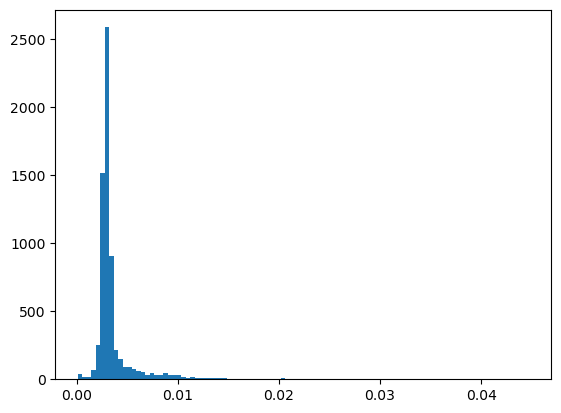

Avg energy: 0.009048193518440568
Avg stdev: 0.003645774295372095


In [45]:
# Cl stdev
plt.hist(cl_stdev, bins=100)
plt.show()
print('Avg energy:',np.mean(cl_energies))
print('Avg stdev:',np.mean(cl_stdev))

In [27]:
math.isqrt(len(o_df))

108

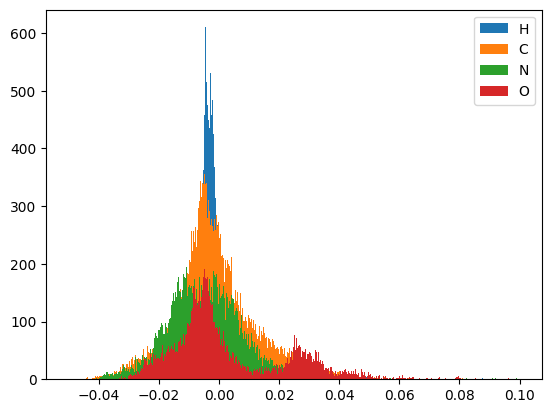

In [28]:
# Overlayed histogram of atomic energy contributions by atom types: 

plt.hist(h_energies, bins=3000, range=[-0.05,0.1], label='H')
plt.hist(c_energies, bins=1000, range=[-0.05,0.1], label='C')
plt.hist(n_energies, bins=500, range=[-0.05,0.1], label='N')
plt.hist(o_energies, bins=500, range=[-0.05,0.1], label='O')
plt.legend(loc='upper right')
plt.show()

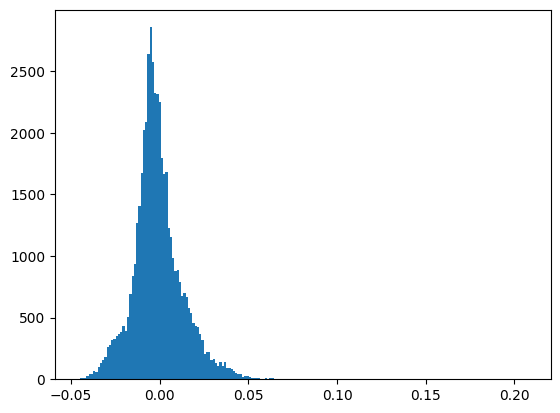

Avg energy: -0.001006288099893805
Avg stdev: 0.00583959232317897


In [29]:
# C energies
plt.hist(c_energies, bins=200)
plt.show()
print('Avg energy:',np.mean(c_energies))
print('Avg stdev:',np.mean(c_stdev))

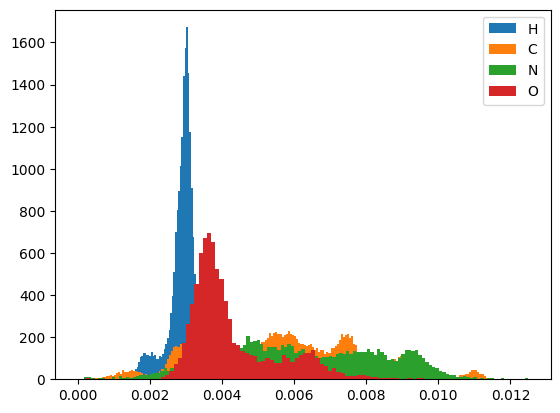

In [30]:
# Overlayed histogram of standard deviations for atomic energy contributions by atom type: 

plt.hist(h_stdev, bins=(math.isqrt(len(h_df))), label='H', range=[0,0.0125], density=True)
plt.hist(c_stdev, bins=(math.isqrt(len(c_df))), label='C', range=[0,0.0125], density=True)
plt.hist(n_stdev, bins=(math.isqrt(len(n_df))), label='N', range=[0,0.0125], density=True)
plt.hist(o_stdev, bins=(math.isqrt(len(o_df))), label='O', range=[0,0.0125], density=True)
plt.legend(loc='upper right')
plt.show()

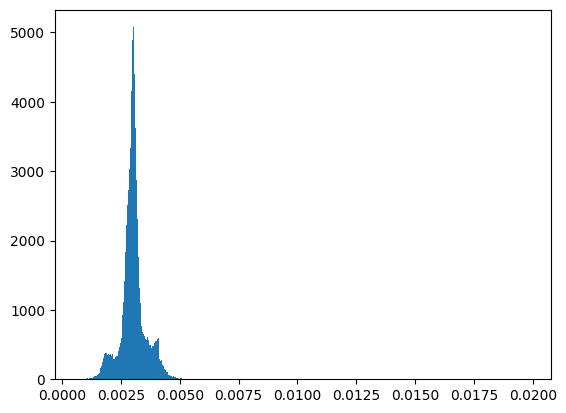

Avg energy: -0.00022971485588094034
Avg stdev: 0.003027370343574863


In [31]:
# Hydrogen histograms
plt.hist(h_stdev, bins=500)#, range=[0.001,0.0055])
plt.show()
print('Avg energy:', np.mean(h_energies))
print('Avg stdev:',np.mean(h_stdev))

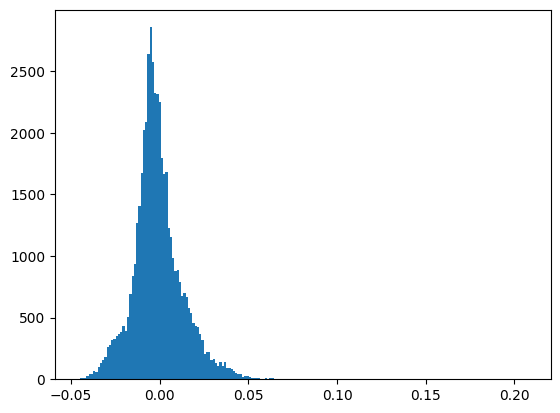

Avg energy: -0.001006288099893805
Avg stdev: 0.00583959232317897


In [32]:
# C energies
plt.hist(c_energies, bins=200)
plt.show()
print('Avg energy:',np.mean(c_energies))
print('Avg stdev:',np.mean(c_stdev))

In [50]:
min_ch4 = (torch.tensor([[6, 1, 1, 1, 1]]),
           torch.tensor([[[-3.2947064558, 0.6540086535, 0.4313881687],
                          [-2.2029514828, 0.6763552943, 0.4373590881],
                          [-3.6556797933, 0.7756014079, -0.5920264340],
                          [-3.6788104313, 1.4664338298, 1.0517860346],
                          [-3.6413841972, -0.3023558975, 0.8284340142]]]))

ani2x.atomic_qbcs(min_ch4).ae_stdev

tensor([[0.0127, 0.0032, 0.0032, 0.0032, 0.0032]], grad_fn=<StdBackward0>)

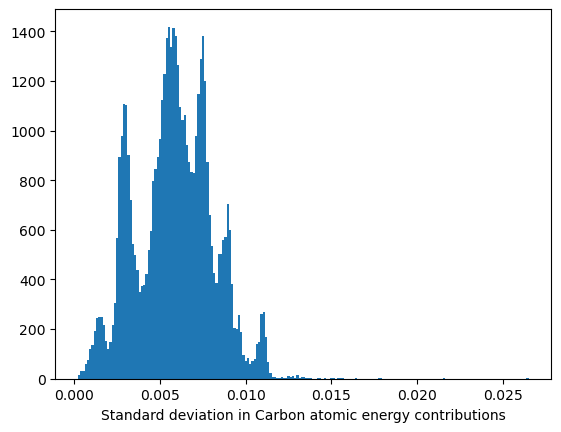

Avg energy: -0.001006288099893795
Avg stdev: 0.00583959232317892


In [51]:
# Carbon histograms

plt.hist(c_stdev, bins=200) #, range=[0.,0.014])
plt.xlabel('Standard deviation in Carbon atomic energy contributions')
plt.show()
print('Avg energy:',np.mean(c_energies))
print('Avg stdev:',np.mean(c_stdev))

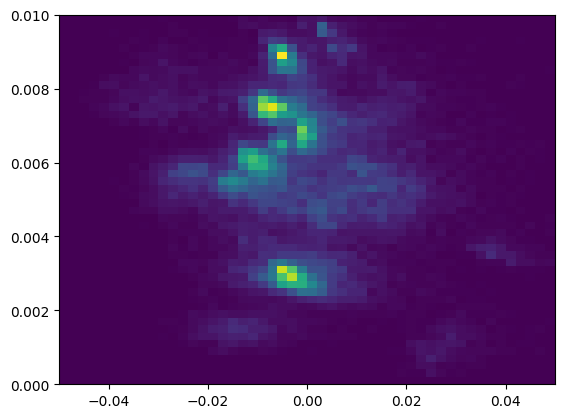

In [34]:
x = c_energies
y = c_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])
plt.show()

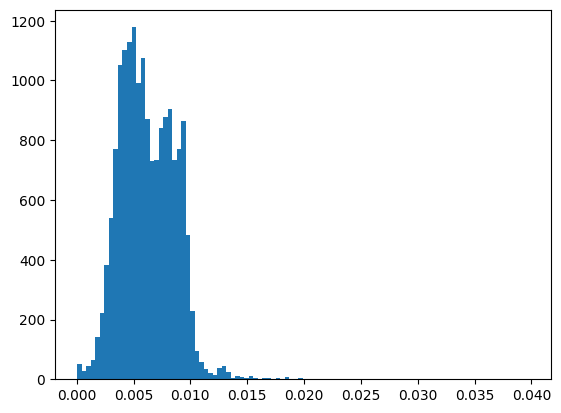

Avg energy: -0.0038776516370790754
Avg stdev: 0.006218335930675646


In [35]:
# Nitrogen histograms

plt.hist(n_stdev, bins=100) #, range=[0.0,0.0175])
plt.show()
print('Avg energy:',np.mean(n_energies))
print('Avg stdev:',np.mean(n_stdev))

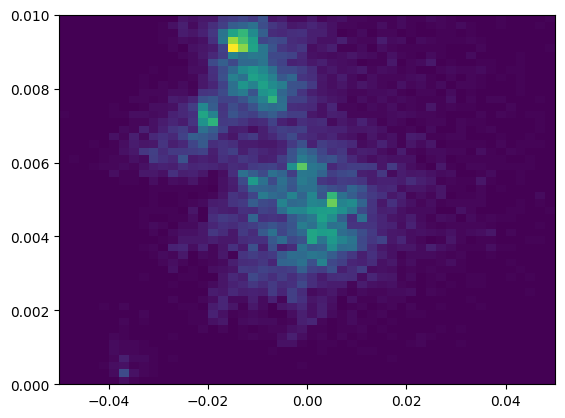

In [36]:
x = n_energies
y = n_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])
plt.show()

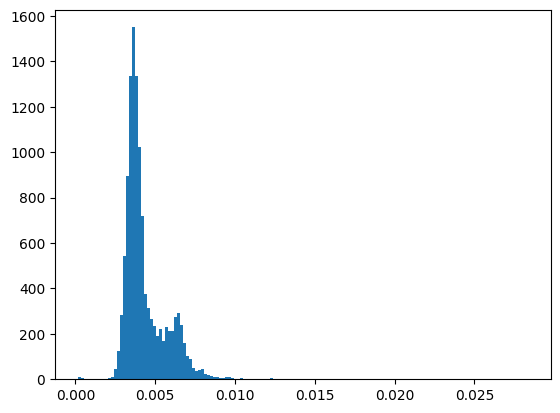

Avg energy: 0.0038586794253999556
Avg stdev: 0.0043581209449324336


In [37]:
# Oxygen histograms

plt.hist(o_stdev, bins=150)#, range=[0.001,0.01])
plt.show()
print('Avg energy:',np.mean(o_energies))
print('Avg stdev:',np.mean(o_stdev))

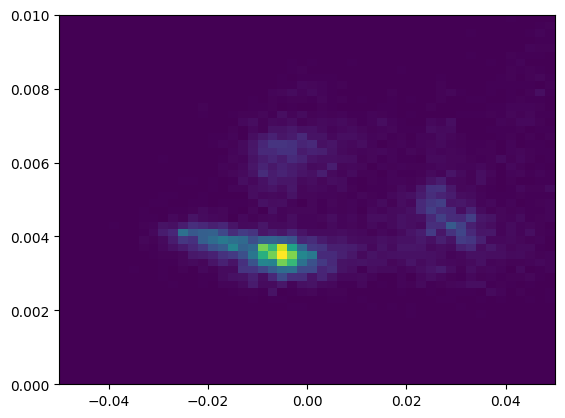

In [38]:
x = o_energies
y = o_stdev
plt.hist2d(x,y,bins=(50,50),range=[[-0.05,0.05],[0,0.01]])#, cmap=plt.cm.Reds)
plt.show()

In [ ]:
avg_qbc = df['QBC'].mean().item()
avg_atomic_stdev = df['Stdev'].mean()
print('Avg atomic e stdev:',hartree2kcalmol(avg_atomic_stdev), 'kcal/mol')
print('Avg qbc factor:    ',hartree2kcalmol(avg_qbc), 'kcal/mol')